Попробуйте обучить нейронную сеть U-Net на любом другом датасете. Напишите в комментариях к уроку, какого результата вы добились от нейросети, что помогло улучшить её точность?


In [4]:
from IPython.display import clear_output
!pip install tf_explain
clear_output()

In [6]:
#import seaborn as sns
#from tensorflow import keras
#import tensorflow_datasets as tfds
import cv2
import PIL
from IPython.display import clear_output
# common

from sklearn.model_selection import train_test_split 
import os
import keras
import numpy as np
import pandas as pd
from glob import glob
import tensorflow as tf
import tensorflow.image as tfi

# Data
from keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

# Data Viz
import matplotlib.pyplot as plt

# Model 
from keras.models import Model
from keras.layers import Layer
from keras.layers import Conv2D
from keras.layers import Dropout
from keras.layers import UpSampling2D
from keras.layers import concatenate
from keras.layers import Add
from keras.layers import Multiply
from keras.layers import Input
from keras.layers import MaxPool2D
from keras.layers import BatchNormalization

# Callbacks 
from keras.callbacks import Callback
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from tf_explain.core.grad_cam import GradCAM

# Metrics
from keras.metrics import MeanIoU

from sklearn.model_selection import train_test_split 

## Загрузка изображений и масок

In [7]:
def load_image(image, SIZE):
    return np.round(tfi.resize(img_to_array(load_img(image))/255.,(SIZE, SIZE)),4)

def load_images(image_paths, SIZE, mask=False, trim=None):
    if trim is not None:
        image_paths = image_paths[:trim]
        
    if mask:
        images = np.zeros(shape=(len(image_paths), SIZE, SIZE, 1))
    else:
        images = np.zeros(shape=(len(image_paths), SIZE, SIZE, 3))
    
    for i,image in enumerate(image_paths):
        img = load_image(image,SIZE)
        if mask:
            images[i] = img[:,:,:1]
        else:
            images[i] = img
    
    return images

def show_image(image, title=None, cmap=None, alpha=1):
    plt.imshow(image, cmap=cmap, alpha=alpha)
    if title is not None:
        plt.title(title)
    plt.axis('off')

def show_mask(image, mask, cmap=None, alpha=0.4):
    plt.imshow(image)
    plt.imshow(tf.squeeze(mask), cmap=cmap, alpha=alpha)
    plt.axis('off')

In [8]:
SIZE = 256
root_path = '../input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT/'
classes = sorted(os.listdir(root_path))
classes

['benign', 'malignant', 'normal']

In [10]:
single_mask_paths = sorted([sorted(glob(root_path + name + "/*mask.png")) for name in classes])
double_mask_paths = sorted([sorted(glob(root_path + name + "/*mask_1.png")) for name in classes])

In [11]:
image_paths = []
mask_paths = []
for class_path in single_mask_paths:
    for path in class_path:
        img_path = path.replace('_mask','')
        image_paths.append(img_path)
        mask_paths.append(path)

In [12]:
images = load_images(image_paths, SIZE)
masks = load_images(mask_paths, SIZE, mask=True)

## Визуализация опухоли и маски

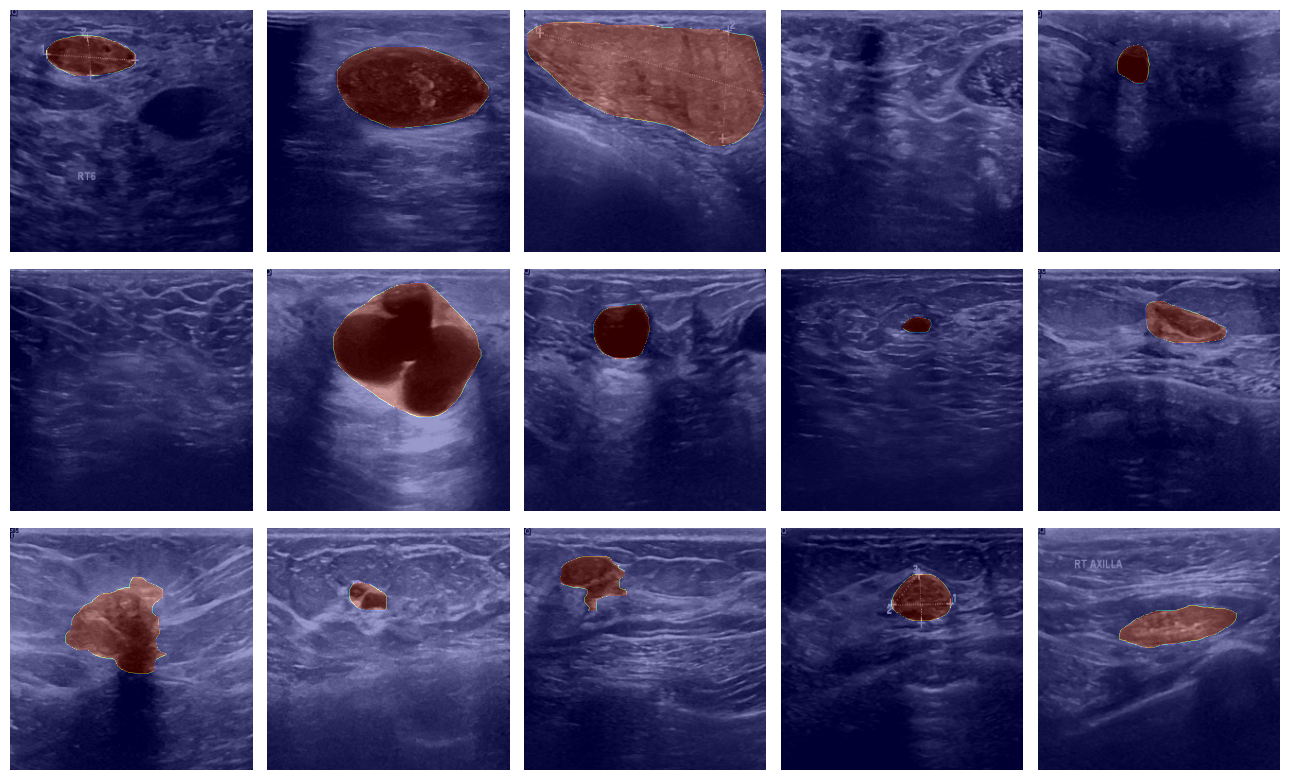

In [13]:
plt.figure(figsize=(13,8))
for i in range(15):
    plt.subplot(3,5,i+1)
    id = np.random.randint(len(images))
    show_mask(images[id], masks[id], cmap='jet')
plt.tight_layout()
plt.show()

## Разделение на трейн и тест

In [14]:
train, test, train_mask, test_mask = train_test_split(images, masks, test_size=0.2, random_state=44)

In [16]:
def normalize(image):

    img = tf.cast(image, dtype=tf.float32) / 255.0 # tf.cast приводит тензор к новому типу.
    #mask -= 1
    return img

In [17]:
train, test = normalize(train), normalize(test)

In [18]:
train.shape, test.shape, train_mask.shape, test_mask.shape

(TensorShape([624, 256, 256, 3]),
 TensorShape([156, 256, 256, 3]),
 (624, 256, 256, 1),
 (156, 256, 256, 1))

In [19]:
#TRAIN_LENGTH = info.splits['train'].num_examples

# Batch size is the number of examples used in one training example.
# It is mostly a power of 2
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = 624 // BATCH_SIZE

# For VGG16 this is the input size
width, height = SIZE, SIZE


## Построение модели

In [20]:

base_model = keras.applications.vgg16.VGG16(
    include_top=False, input_shape=(width, height, 3))

layer_names = [
    'block1_pool',
    'block2_pool',
    'block3_pool',
    'block4_pool',
    'block5_pool',
]
base_model_outputs = [base_model.get_layer(
    name).output for name in layer_names]
base_model.trainable = False

VGG_16 = tf.keras.models.Model(base_model.input,
                               base_model_outputs)

58889256/58889256 [==============================] - 0s 0us/step


In [24]:
def fcn8_decoder(convs, n_classes):
	f1, f2, f3, f4, p5 = convs

	n = 4096
	c6 = tf.keras.layers.Conv2D(
		n, (7, 7), activation='relu', padding='same',
	name="conv6")(p5)
	c7 = tf.keras.layers.Conv2D(
		n, (1, 1), activation='relu', padding='same',
	name="conv7")(c6)

	f5 = c7

	# upsample the output of the encoder
	# then crop extra pixels that were introduced
	o = tf.keras.layers.Conv2DTranspose(n_classes, kernel_size=(
		4, 4), strides=(2, 2), use_bias=False)(f5)
	o = tf.keras.layers.Cropping2D(cropping=(1, 1))(o)

	# load the pool 4 prediction and do a 1x1
	# convolution to reshape it to the same shape of `o` above
	o2 = f4
	o2 = (tf.keras.layers.Conv2D(n_classes, (1, 1),
								activation='relu',
								padding='same'))(o2)

	# add the results of the upsampling and pool 4 prediction
	o = tf.keras.layers.Add()([o, o2])

	# upsample the resulting tensor of the operation you just did
	o = (tf.keras.layers.Conv2DTranspose(
		n_classes, kernel_size=(4, 4), strides=(2, 2),
	use_bias=False))(o)
	o = tf.keras.layers.Cropping2D(cropping=(1, 1))(o)

	# load the pool 3 prediction and do a 1x1
	# convolution to reshape it to the same shape of `o` above
	o2 = f3
	o2 = (tf.keras.layers.Conv2D(n_classes, (1, 1),
								activation='relu',
								padding='same'))(o2)

	# add the results of the upsampling and pool 3 prediction
	o = tf.keras.layers.Add()([o, o2])

	# upsample up to the size of the original image
	o = tf.keras.layers.Conv2DTranspose(
		n_classes, kernel_size=(8, 8), strides=(8, 8),
	use_bias=False)(o)

	# append a softmax to get the class probabilities
	o = tf.keras.layers.Activation('softmax')(o)
	return o


In [30]:
def segmentation_model():

	inputs = keras.layers.Input(shape=(width, height, 3))
	convs = VGG_16(inputs)
	outputs = fcn8_decoder(convs, 3)
	model = tf.keras.Model(inputs=inputs, outputs=outputs)

	return model



In [33]:
opt = keras.optimizers.Adam()

model = segmentation_model()
model.compile(optimizer=opt,
			loss=tf.keras.losses.SparseCategoricalCrossentropy(
				from_logits=True),
			metrics=['accuracy'])

In [36]:
# Config Training
BATCH_SIZE = 8
SPE = len(images)//BATCH_SIZE

# Training
results = model.fit(
    train, train_mask,
    epochs=33, # 15 will be enough for a good Model for better model go with 20+
    steps_per_epoch=SPE,
    validation_data=(test, test_mask),
    batch_size=BATCH_SIZE)

Epoch 1/33
97/97 [==============================] - 28s 289ms/step - loss: 0.2229 - accuracy: 0.9188 - val_loss: 0.1999 - val_accuracy: 0.9327
Epoch 2/33
97/97 [==============================] - 27s 283ms/step - loss: 0.2199 - accuracy: 0.9204 - val_loss: 0.2049 - val_accuracy: 0.9327
Epoch 3/33
97/97 [==============================] - 27s 281ms/step - loss: 0.2265 - accuracy: 0.9179 - val_loss: 0.1982 - val_accuracy: 0.9327
Epoch 4/33
97/97 [==============================] - 27s 283ms/step - loss: 0.2244 - accuracy: 0.9193 - val_loss: 0.2052 - val_accuracy: 0.9327
Epoch 5/33
97/97 [==============================] - 27s 282ms/step - loss: 0.2264 - accuracy: 0.9169 - val_loss: 0.2011 - val_accuracy: 0.9327
Epoch 6/33
97/97 [==============================] - 27s 282ms/step - loss: 0.2210 - accuracy: 0.9207 - val_loss: 0.1989 - val_accuracy: 0.9327
Epoch 7/33
97/97 [==============================] - 27s 283ms/step - loss: 0.2212 - accuracy: 0.9190 - val_loss: 0.2023 - val_accuracy: 0.9327

In [39]:
# Config Training
BATCH_SIZE = 8
SPE = len(images)//BATCH_SIZE

# Training
results = model.fit(images, masks,
    epochs=17, # 15 will be enough for a good Model for better model go with 20+
    steps_per_epoch=SPE,
    validation_split=0.2,
    validation_data=(test, test_mask),
    batch_size=BATCH_SIZE)

Epoch 1/17
97/97 [==============================] - 28s 286ms/step - loss: 0.2036 - accuracy: 0.9220 - val_loss: 0.2704 - val_accuracy: 0.9327
Epoch 2/17
97/97 [==============================] - 28s 287ms/step - loss: 0.1608 - accuracy: 0.9276 - val_loss: 0.3128 - val_accuracy: 0.9072
Epoch 3/17
97/97 [==============================] - 27s 281ms/step - loss: 0.1408 - accuracy: 0.9405 - val_loss: 0.3986 - val_accuracy: 0.7677
Epoch 4/17
97/97 [==============================] - 27s 284ms/step - loss: 0.1212 - accuracy: 0.9508 - val_loss: 0.3790 - val_accuracy: 0.7851
Epoch 5/17
97/97 [==============================] - 28s 284ms/step - loss: 0.1093 - accuracy: 0.9551 - val_loss: 0.3129 - val_accuracy: 0.8563
Epoch 6/17
97/97 [==============================] - 27s 283ms/step - loss: 0.1006 - accuracy: 0.9590 - val_loss: 0.4905 - val_accuracy: 0.7227
Epoch 7/17
97/97 [==============================] - 27s 283ms/step - loss: 0.0915 - accuracy: 0.9627 - val_loss: 0.4022 - val_accuracy: 0.7776

# Итог
* Для достижения оптимальных зщначений вал лос что при фиксированом валиационном наборе что при использовании сплита требуется изменение модели либо выбор другого оптимизатора. 
* В ходе работы были опробованиы такие оптмизаторы как SGD Нестеров и Adam самым оптимальным вариантом оказался Adam другиеоптимизаторы градиентного спуска тр5бовали больше эпох обучения для достижении тех же значении потерь.
* Для достижения оптимума в случе использовани validation_split=0.2 нам явно будет требоватся еще больше эпох обучения либо изменения архитектуры, так же хорощей идей будет добавить в градиентный спуск шага эта меняющегося в зависимости от значения потерь

###